In [1]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, Statistics, DataFrames, JLD2

## Import files

In [2]:
# Station information
stations_info = CSV.read("../../data/stations/station_information.csv", DataFrame);
# Capacities
C_full = stations_info[!, :capacity];
# Distances
D_full = load("../../data/parameters/distances.jld2", "D");
# Feasibility
X_full = load("../../data/parameters/feasibility.jld2", "X");
# demand
demand_full = load("../../data/parameters/202210-demand.jld2", "demand");

## Input parameters

In [3]:
# Initial state 
y0_full = floor.(C_full/2);
# demand over one day
# Day 1
d_full = demand_full[:,:,1:24];
# Day 8
d_2_full = demand_full[:,:,169:192];
# Day 15
d_3_full = demand_full[:,:,337:360];

## Problem size reduction

In [4]:
function reduce_problem(d,C,y0,D,X,nb)
    n_stations = size(d,1)
    stations_score = zeros(n_stations)
    # for each station i, sum the number of bikes that gets in an out ot the station over the month
    for i in 1:n_stations
        stations_score[i] += sum(d[i,:,:]) + sum(d[:,i,:])
    end
    # sort stations by score
    stations_score_sorted = sortperm(stations_score, rev=true);
    # reorder index of columns and rows according to the sorted stations
    d_sorted = d[stations_score_sorted, stations_score_sorted, :];
    C_sorted = C[stations_score_sorted,:];
    y0_sorted = y0[stations_score_sorted,:];
    D_sorted = D[stations_score_sorted, stations_score_sorted];
    X_sorted = X[stations_score_sorted, stations_score_sorted];
    # keep only the nb first stations
    d_new = d_sorted[1:nb,1:nb,:];
    C_new = C_sorted[1:nb,:];
    y0_new = y0_sorted[1:nb,:];
    D_new = D_sorted[1:nb,1:nb];
    X_new = X_sorted[1:nb,1:nb];
    return d_new, C_new, y0_new, D_new, X_new
end

reduce_problem (generic function with 1 method)

In [5]:
# for day 1
d, C, y0, D, X = reduce_problem(d_full,C_full,y0_full,D_full,X_full,200);
# for day 8
d_2, C, y0, D, X = reduce_problem(d_2_full,C_full,y0_full,D_full,X_full,200);
# for day 15
d_3, C, y0, D, X = reduce_problem(d_3_full,C_full,y0_full,D_full,X_full,200);

### Robustness: Create slightly different demand for day 1: d_bis

In [6]:
function create_d_bis(d_1,d_2)
    diff = d_2 - d_1
    n_stations = size(d_1,1)
    d_bis=zeros(n_stations,n_stations,24)
    for i in 1:n_stations
        for j in 1:n_stations
            for l in 1:24
                ecart=floor(diff[i,j,l]/2)
                if ecart>0
                    d_bis[i,j,l] = d_1[i,j,l] + rand(0:ecart)
                else
                    d_bis[i,j,l] = d_1[i,j,l] + rand(ecart:0)
                end
            end
        end
    end
    return d_bis
end

create_d_bis (generic function with 1 method)

In [7]:
d_bis=create_d_bis(d, d_2);

# Model

In [8]:
function solve_model(K,S,C,D,X,y0,d, lambda, n_rebal)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "TimeLimit", 100)

    n_stations, _, n_hours = size(d)

    # Decision variables
    @variable(model, x[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Bin)
    @variable(model, 0 <= z[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Int)
    @variable(model, 0 <= y[1:n_stations, 1:n_hours]) # Int by definition of the constraints
    @variable(model, 0 <= w[1:n_stations, 1:n_stations, 1:n_hours], Int)
    @variable(model, 0 <= u[1:n_stations, 1:n_stations, 1:n_hours])

    # Add constraints:
    # Stations capacity
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], y[i,t] <= C[i])
    # No rebalancing at the same station
    @constraint(model, [i in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,i,k,t] == 0)
    # Flow balance 
    @constraint(model, [i in 1:n_rebal, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations)-sum(z[i,j,k,t] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,t] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations))
    # Flow balance for the first hour 
    @constraint(model, [i in 1:n_rebal], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations)-sum(z[i,j,k,1] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,1] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations))
    # Vans capacity
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S)
    # Users travel availability
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], -y[i,t] <= sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations))
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations)<= C[i] - y[i,t])
    # Max 1 rebalancing per hour per van
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal) <= 1)
    # Rebalancing feasibility
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S*x[i,j,k,t])
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,j,k,t] <= X[i,j])
    # Users travel is inferior to the d and definition of u
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], u[i,j,t] >= d[i,j,t] - w[i,j,t])
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], d[i,j,t] >= w[i,j,t])

    # Set objective
    @objective(model, Min, sum(u[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours)+lambda*sum(D[i,j]*x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))
    
    # Solve the model
    optimize!(model)
    
    # Print the solution
    println("Objective value: ", objective_value(model))
    return value.(x), value.(w), value.(u), value.(y), value.(z), objective_value(model)
end

solve_model (generic function with 1 method)

In [60]:
function solve_sequential_model(K,S,C,D,X,y0,d, lambda, n_rebal)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "TimeLimit", 1000)

    n_stations, _, n_hours = size(d)
    
    # Decision variables
    @variable(model, x[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Bin)
    @variable(model, v[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Bin)
    @variable(model, 0 <= z[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Int)
    @variable(model, 0 <= y[1:n_stations, 1:n_hours]) # Int by definition of the constraints
    @variable(model, 0 <= w[1:n_stations, 1:n_stations, 1:n_hours], Int)
    @variable(model, 0 <= u[1:n_stations, 1:n_stations, 1:n_hours])

    # Add constraints:
    # Stations capacity
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], y[i,t] <= C[i])
    # Flow balance 
    @constraint(model, [i in 1:n_rebal, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations)-sum(z[i,j,k,t] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,t] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations))
    # Flow balance for the first hour 
    @constraint(model, [i in 1:n_rebal], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations)-sum(z[i,j,k,1] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,1] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations))
    # Vans capacity
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S)
    # Users travel availability
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], -y[i,t] <= sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations))
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations)<= C[i] - y[i,t])
    # Max 1 rebalancing per hour per van
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal) == 1)
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(v[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal) == 1)
    # Rebalancing feasibility
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S*x[i,j,k,t])
    for i in 1:n_rebal
        for j in 1:n_rebal
            if X[i,j] == 0
                for k in 1:K
                    for t in 1:n_hours
                        @constraint(model, x[i,j,k,t] == 0)
                        @constraint(model, v[i,j,k,t] == 0)
                        @constraint(model, z[i,j,k,t] == 0)
                    end
                end
            end
        end
    end
   # Vans must travel sequentially
    @constraint(model, [i in 1:n_rebal, k in 1:K, t in 2:n_hours], sum(x[i,j,k,t] for j in 1:n_rebal) <= sum(v[l,i,k,t-1] for l in 1:n_rebal))
    @constraint(model, [j in 1:n_rebal, k in 1:K, t in 1:n_hours], sum(v[j,l,k,t] for l in 1:n_rebal) <= sum(x[i,j,k,t] for i in 1:n_rebal))
    # Users travel is inferior to the demand and definition of u
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], u[i,j,t] >= d[i,j,t] - w[i,j,t])
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], d[i,j,t] >= w[i,j,t])

    # Set objective
    @objective(model, Min, sum(u[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours)+lambda*sum(D[i,j]*(x[i,j,k,t]+v[i,j,k,t]/10) for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))
    
    # Solve the model
    optimize!(model)
    
    # Print the solution
    println("Objective value: ", objective_value(model))
    return value.(x), value.(v), value.(w), value.(u), value.(y), value.(z), objective_value(model)
end

solve_sequential_model (generic function with 1 method)

In [61]:
for i in 1:200
    X[i,i] = 1
end

In [62]:
function export_results(z)
    z_nonzero = Tuple.(findall(x -> x != 0, z))[:,:]
    nb_rebal = size(z_nonzero)[1]
    new=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(z_nonzero[i])
        new[i,1:4]=indices # indices of rebalancing
        new[i,5]=z[indices[1],indices[2],indices[3],indices[4]] # nb of bikes
    end
    return new
end

export_results (generic function with 1 method)

In [63]:
function export_sequential_results(z,v)
    z_nonzero = Tuple.(findall(x -> x != 0, z))[:,:]
    nb_rebal = size(z_nonzero)[1]
    new=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(z_nonzero[i])
        new[i,1:4]=indices # indices of rebalancing
        new[i,5]=z[indices[1],indices[2],indices[3],indices[4]] # nb of bikes
    end
    v_nonzero = Tuple.(findall(x -> x != 0, v))[:,:]
    nb_rebal = size(v_nonzero)[1]
    new2=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(v_nonzero[i])
        new2[i,1:4]=indices # indices of rebalancing
        new2[i,5]=0
    end
    return vcat(new,new2)
end

export_sequential_results (generic function with 1 method)

### Parameters

In [64]:
# Number of vans
K=1
# Capacity of vans
S=25
# stations for rebalancing 
n_rebal = 50; # Top 50 according to station scores
# Trade-off for multi-objective
lambda=15; # to be tuned according to the objectives scales

In [65]:
function print_results(results)
    for i=1:size(results)[1]
        println("Rebalancing from station ",results[i,1], " to ", results[i,2], "by van ", results[i,3], " at hour ", results[i,4]," of ", results[i,5]," bikes ")
    end
end

print_results (generic function with 1 method)

## Solve for Day 1

In [66]:
# x_1,w_1,u_1,y_1,z_1,obj_1=solve_model(K,S,C,D,X,y0,d,lambda,n_rebal);
x_1,v_1, w_1,u_1,y_1,z_1,obj_1=solve_sequential_model(K,S,C,D,X,y0,d,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 1000
Objective value: 995.6646859888951


In [ ]:
sum(sum(z_1[i,i,:,:] for i in 1:n_rebal))

0.0

In [ ]:
findall(x -> x != 0, z_1[:,:,:,:])

5-element Vector{CartesianIndex{4}}:
 CartesianIndex(16, 4, 1, 11)
 CartesianIndex(4, 16, 1, 14)
 CartesianIndex(16, 4, 1, 15)
 CartesianIndex(4, 16, 1, 18)
 CartesianIndex(16, 4, 1, 19)

In [ ]:
# Count the number of non-moving trips
non_moving=sum(sum(x_1[i,i,:,:] for i in 1:n_rebal))
# Count the number of rebalancing trips
rebalancing=sum(sum(x_1[i,j,:,:] for i in 1:n_rebal, j in 1:n_rebal))-non_moving

5.0

In [ ]:
results = export_sequential_results(z_1,v_1);
CSV.write("../../results/data/sequential_model_day1/results.csv", results |> Tables.table)

"../../results/data/sequential_model_day1/results.csv"

In [ ]:
print_results(export_results(z_1))

Rebalancing from station 30.0 to 20.0by van 1.0 at hour 1.0 of 11.0 bikes 
Rebalancing from station 16.0 to 4.0by van 2.0 at hour 1.0 of 3.0 bikes 
Rebalancing from station 2.0 to 30.0by van 1.0 at hour 2.0 of 8.0 bikes 
Rebalancing from station 3.0 to 25.0by van 3.0 at hour 3.0 of 4.0 bikes 
Rebalancing from station 3.0 to 25.0by van 3.0 at hour 5.0 of 2.0 bikes 
Rebalancing from station 4.0 to 16.0by van 2.0 at hour 7.0 of 2.0 bikes 
Rebalancing from station 3.0 to 13.0by van 3.0 at hour 7.0 of 6.0 bikes 
Rebalancing from station 20.0 to 30.0by van 1.0 at hour 8.0 of 4.0 bikes 
Rebalancing from station 16.0 to 4.0by van 2.0 at hour 8.0 of 2.0 bikes 
Rebalancing from station 13.0 to 3.0by van 3.0 at hour 8.0 of 11.0 bikes 
Rebalancing from station 16.0 to 4.0by van 2.0 at hour 10.0 of 9.0 bikes 
Rebalancing from station 13.0 to 9.0by van 3.0 at hour 10.0 of 8.0 bikes 
Rebalancing from station 2.0 to 20.0by van 1.0 at hour 11.0 of 4.0 bikes 
Rebalancing from station 9.0 to 13.0by van 3

In [27]:
#n_stations, _, n_hours = size(d_new)
#println(sum(u_1[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours))
#println(sum(D_new[i,j]*x_1[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))

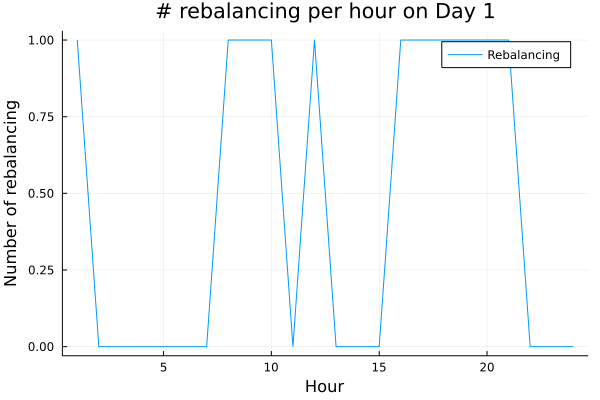

In [28]:
using Plots
plot([sum(x_1[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

In [29]:
res_1=export_results(z_1)
#using Tables
# convert array to csv file
#CSV.write("../../results/data/results_day1_sequential.csv", Tables.table(res_1))
# export demand day 1
#jldsave("../../results/demand_day1.jld2", true; d)

11×5 Matrix{Float64}:
  2.0  20.0  1.0   1.0   8.0
 13.0  37.0  3.0   8.0   9.0
 19.0  39.0  3.0   9.0   3.0
 49.0  12.0  2.0  10.0   9.0
 37.0  13.0  1.0  12.0  10.0
 18.0  27.0  1.0  16.0  10.0
 19.0  39.0  2.0  17.0   7.0
  3.0  25.0  1.0  18.0   9.0
 16.0   4.0  1.0  19.0  10.0
 27.0  18.0  3.0  20.0   7.0
 20.0   2.0  1.0  21.0  10.0

In [31]:
#print_results(res_1)

## Solve for Day 1 - bis

In [32]:
x_1_bis,w_1_bis,u_1_bis,y_1_bis,z_1_bis,obj_1_bis=solve_model(K,S,C,D,X,y0,d_bis,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 650.1747328440262


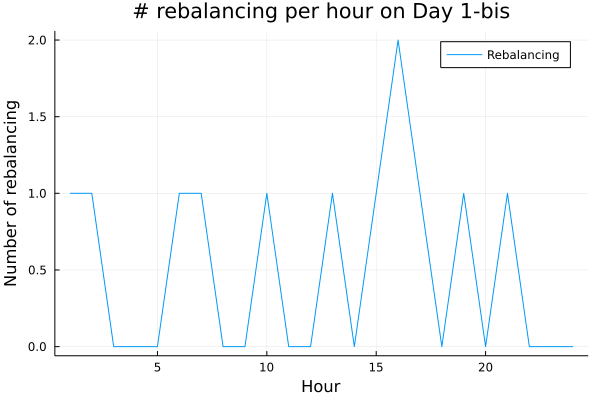

In [33]:
using Plots
plot([sum(x_1_bis[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1-bis")

In [34]:
res_1_bis=export_results(z_1_bis)
res_1_bis

12×5 Matrix{Float64}:
  2.0  20.0  3.0   1.0   7.0
 16.0   4.0  2.0   2.0  10.0
 28.0  40.0  3.0   6.0   9.0
 13.0  37.0  2.0   7.0   5.0
 49.0  26.0  2.0  10.0  10.0
 19.0  39.0  1.0  13.0   2.0
 18.0  27.0  2.0  15.0   6.0
  3.0  25.0  2.0  16.0  10.0
  4.0  16.0  3.0  16.0   9.0
 37.0  13.0  2.0  17.0  10.0
 16.0   4.0  2.0  19.0  10.0
 20.0   2.0  3.0  21.0  10.0

## Solve for Day 8

In [291]:
x_2,w_2,u_2,y_2,z_2,obj_2=solve_model(K,S,C,D,X,y0,d_2,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 1267.9000444622236


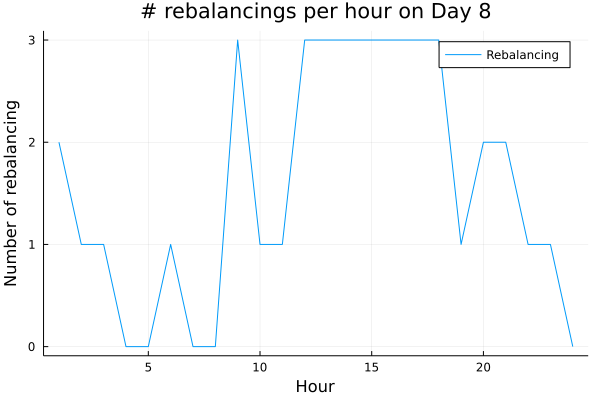

In [292]:
using Plots
plot([sum(x_2[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancings per hour on Day 8")

In [293]:
res_2=export_results(z_2)

38×5 Matrix{Float64}:
  4.0  16.0  2.0   1.0   5.0
 25.0  43.0  3.0   1.0   5.0
  9.0  10.0  1.0   2.0   5.0
 28.0  40.0  1.0   3.0   3.0
  1.0  50.0  2.0   6.0   6.0
 17.0  15.0  1.0   9.0   9.0
 28.0  40.0  2.0   9.0  10.0
 16.0  14.0  3.0   9.0   8.0
 41.0  19.0  2.0  10.0   7.0
  3.0  44.0  3.0  11.0   6.0
  2.0  20.0  1.0  12.0  10.0
  2.0  30.0  2.0  12.0  10.0
  3.0  44.0  3.0  12.0  10.0
  ⋮                     
  9.0  13.0  2.0  17.0  10.0
  8.0  35.0  3.0  17.0  10.0
 13.0  37.0  1.0  18.0   8.0
  7.0  21.0  2.0  18.0  10.0
 30.0  20.0  3.0  18.0   7.0
  4.0   5.0  3.0  19.0   5.0
  2.0   6.0  1.0  20.0  10.0
  3.0  13.0  2.0  20.0  10.0
 13.0   3.0  1.0  21.0   7.0
 40.0  28.0  2.0  21.0   5.0
  4.0  16.0  1.0  22.0   5.0
 11.0  42.0  2.0  23.0  10.0

## Solve for Day 15

In [294]:
x_3,w_3,u_3,y_3,z_3,obj_3=solve_model(K,S,C,D,X,y0,d_3,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 1572.7418991707546


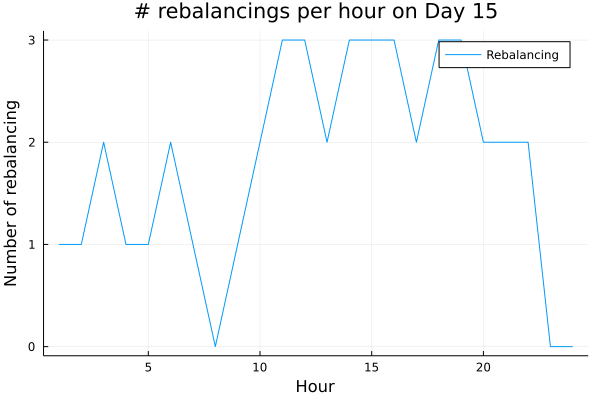

In [295]:
using Plots
plot([sum(x_3[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancings per hour on Day 15")

In [296]:
res_3=export_results(z_3)

43×5 Matrix{Float64}:
 12.0  49.0  3.0   1.0   9.0
 28.0  34.0  3.0   2.0   9.0
  9.0  10.0  2.0   3.0  10.0
  4.0   5.0  3.0   3.0   6.0
  6.0  43.0  1.0   4.0  10.0
  8.0  35.0  1.0   5.0   8.0
  1.0   9.0  2.0   6.0   7.0
  3.0  44.0  3.0   6.0   8.0
  7.0  21.0  1.0   7.0   9.0
 20.0   6.0  2.0   9.0  10.0
 30.0   6.0  1.0  10.0  10.0
 27.0  18.0  2.0  10.0   5.0
  4.0  16.0  1.0  11.0  10.0
  ⋮                     
  4.0   5.0  1.0  18.0  10.0
  4.0   5.0  2.0  18.0  10.0
 37.0  13.0  3.0  18.0   8.0
  3.0  37.0  1.0  19.0   8.0
 17.0  15.0  2.0  19.0  10.0
 16.0   4.0  3.0  19.0   8.0
 35.0   8.0  1.0  20.0  10.0
  3.0  25.0  2.0  20.0   9.0
 19.0  39.0  1.0  21.0   1.0
  9.0   1.0  2.0  21.0  10.0
 25.0   3.0  1.0  22.0  10.0
 13.0   3.0  3.0  22.0   5.0

## Dummy data

In [17]:
# capacity of stations
C = [10,10,10,10];

# d of stations
d = [[[0,10,0,5] [0,0,0,0] [0,5,0,0] [20,0,0,0]];;;
    [[0,0,0,0] [0,0,0,0] [30,0,0,0] [0,10,0,0]];;;
    [[0,0,0,5] [0,0,15,0] [0,0,0,0] [0,0,0,0]]];

# proximity of stations
X = [[0,1,1,1] [1,0,1,1] [1,1,0,1] [1,1,1,0]];

# capacity of stations
y0 = [6,2,4,3];

# number of vans
K = 2;

# capacity of vans
S = 20;

# distance of stations
D = [[0,0.5,1,0.5] [2,0,0.5,1] [0.5,1,0,0.5] [1,2,1,0]];

# number of stations
n_stations = 4;
n_hours=3;